[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_08_descenso_gradiente-published.ipynb)

# Descenso por gradiente

Vamos a explorar el método de descenso por gradiente para el cómputo de una regresión lineal.


In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from typing import Callable, Dict, Optional, Any

#### Datos para trabajar

Tenemos los siguientes datos generados al azar para ser ajustados por una regresión.

In [2]:
bias = 500
X, y, coef = make_regression(n_samples=5000, 
                             n_features=3, 
                             bias= bias,
                             noise=1, random_state=42, coef=True)

print(f"Generamos una matriz de {X.shape[0]} de observaciones de {X.shape[1]} atributos\n" + 
      f"Target en el rango {(round(min(y),2), round(max(y),2))}\n" + 
      f"los coeficientes con los que fueron generados son: {coef}")

print(f"Y = {bias} + {' + '.join([str(round(c,2)) + ' * X' + str(idx+1) for idx,c in enumerate(coef)])} + ε")

Generamos una matriz de 5000 de observaciones de 3 atributos
Target en el rango (np.float64(113.11), np.float64(865.44))
los coeficientes con los que fueron generados son: [38.95952484  1.51074456 89.82730651]
Y = 500 + 38.96 * X1 + 1.51 * X2 + 89.83 * X3 + ε


Los datos se ven así:

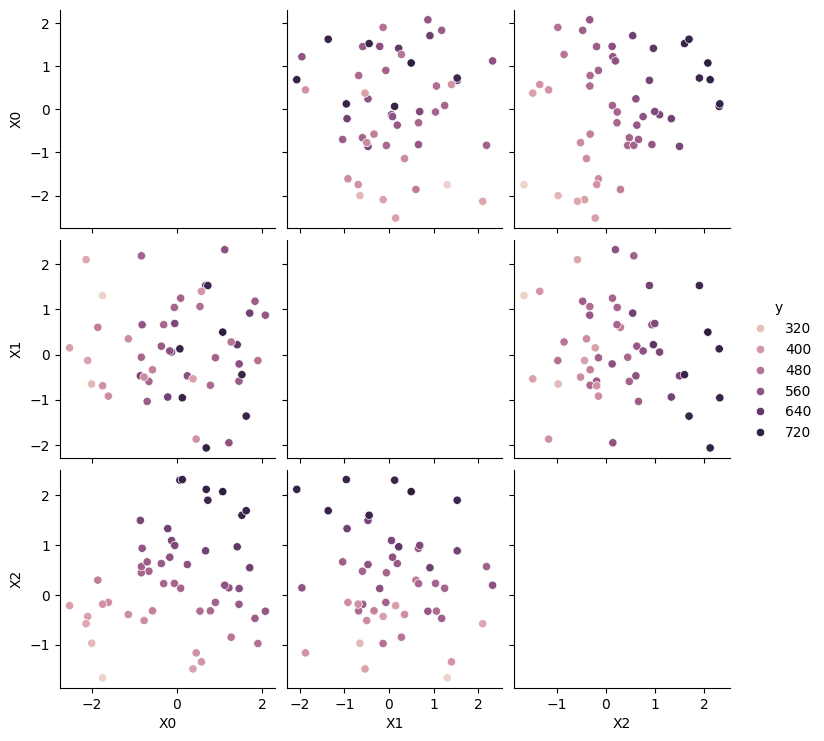

In [3]:
df = pd.DataFrame(X, columns=[f"X{i}" for i in range(X.shape[1])])
df["y"] = y
sns.pairplot(df.sample(50), hue="y")

En este notebook vamos a ver el resultado calculado de diversas formas, por lo que vamos a guardar para cada resultado los w y un valor de error.

In [4]:
# Usamos esta métrica, pero podemos reemplazarla por otra

def error_prediccion(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    # agrego columna para el intercept
    col_ones = np.ones((X.shape[0], 1))
    X_ext = np.hstack((col_ones, X))
    
    predicciones = np.dot(X_ext, w)

    return mean_squared_error(predicciones, y)

Los resultados los almacenaremos en un `DataFrame`.

In [5]:
# Guardo los datos para comparaciones posteriores
resultados = pd.DataFrame(columns=["metodo", "w0", "w1", "w2", "w3", "error_prediccion"])

err = error_prediccion(X, y, np.array([bias] + list(coef)))
resultados.loc[len(resultados)] = ["simulacion", bias] + list(coef) + [err]
resultados

,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500,38.959525,1.510745,89.827307,1.001549


## Descenso por gradiente

Veamos ahora la función general

In [6]:
def descenso_gradiente(g, dg, z_init, alpha, num_iterations, tol, verbose=False):
    """
    Descenso de gradiente para minimizar g. 
    Args:
        g: La función a optimizar. 
        dg: El gradiente de la función.
        z_init: Valor inicial.
        alpha: El 'learning rate'.
        num_iterations: Máx iteraciones.
        tol: Tolerancia para la convergencia. 
    """
    z = z_init
    for _ in range(num_iterations):
        gradient = dg(z) # gradient vale por ej <0.5, -0.2, -3, 0>
        z_new = z - (alpha * gradient)
        if abs(g(z_new) - g(z)) < tol:
            break
        z = z_new
    return z


Con esto es todo lo que necesitamos de descenso por gradiente.

## Regresión lineal

Podemos generarnos una clase que calcula la regresión lineal utilizando el método de  descenso por gradiente y nos devuelva los pesos correspondientes a los w de la regresión.



In [7]:
from sklearn import preprocessing
from functools import partial

class RegresionLinealDG():
    
    def __init__(self,
                 func_costo: Callable[..., float], 
                 func_costo_grad: Callable[..., np.ndarray], 
                 descenso_gradiente_hyperparams: Optional[Dict[str, Any]] = None):
        self.func_costo = func_costo
        self.func_costo_grad = func_costo_grad
        self.descenso_gradiente_hyperparams = descenso_gradiente_hyperparams
        self.collect_info = False
   
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # agrego columna para el intercept
        col_ones = np.ones((X.shape[0], 1))
        X_train_ext = np.hstack((col_ones, X))

        cost_X_y = partial(self.func_costo, X=X_train_ext, y=y)
        grad_cost_X_y = partial(self.func_costo_grad, X=X_train_ext, y=y)       
                    
        w_shape = X_train_ext.shape[1]
        self.w = descenso_gradiente(cost_X_y, grad_cost_X_y, 
                        z_init=np.zeros(w_shape), 
                        **self.descenso_gradiente_hyperparams)


Con la clase `RegresionLinealDG` ya debemos definir en la creación la función de costo y el gradiente que se utilizan en el método (descenso por grandiente).

Empecemos usando MSE:

$MSE_{X,y} = \frac{1}{n} \sum_{i=1}^{n} (\hat{h}_{w_0,w_1,\ldots,w_p}(x^{(i)}) - y^{(i)})^2$

y su gradiente:

$\nabla_{\mathbf{w}} MSE_{X,y}(w) = \frac{2}{n} \sum_{i=1}^{n} (\hat{h}_{w_0,w_1,\ldots,w_p}(x^{(i)}) - y^{(i)}) * x^{(i)}$



In [8]:
def mse(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    y_preds = X @ w
    return (1/len(y)) * np.sum((y_preds - y)**2)
 
def grad_mse(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    y_preds = X @ w
    return (2 / len(y)) * X.T @ (y_preds - y)

Podemos entonces crear nuestra regresión:

In [9]:
hyperparametros = {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}

reg = RegresionLinealDG(mse, grad_mse, hyperparametros)

Entrenarla:

In [10]:
reg.fit(X,y)

Y obtener los w 

In [11]:
print("(DescensoG) w", reg.w.round(1))

err = error_prediccion(X, y, reg.w)
resultados.loc[len(resultados)] = [f"DescensoGradiente {hyperparametros['num_iterations']}"] + list(reg.w) + [err]

(DescensoG) w [499.5  38.9   1.5  89.7]


## Solución analítica

Analogamente, podemos computar el valor analitico de los _w_ con la fórmula:

$w = (X^T X)^{-1} X^T y$

In [12]:
from numpy.linalg import inv

def minimizacion_analitica(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    col_ones = np.ones((X.shape[0], 1))
    X_ext = np.hstack((col_ones, X))
    X_XT_inv = inv(X_ext.T @ X_ext)
    w_analitico = (X_XT_inv @ X_ext.T) @ y

    return w_analitico

Calculemos los w:

In [13]:
w_analitico = minimizacion_analitica(X, y)
print("(Analítico) w", w_analitico.round(1))

err = error_prediccion(X, y, w_analitico)
resultados.loc[len(resultados)] = [f"Analítico"] + list(w_analitico) + [err]
resultados

(Analítico) w [500.   39.    1.5  89.8]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661


# Ejercicios

1. Realizar una grilla para los hyperparámetros de la regresión:

    `{"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}` 
    
    y reportar su comportamiento.

1. Implementar y experimentar el comportamiento con otra función de costo en lugar de MSE, elegir al menos una entre:
    - MSE_Ridge
    - MSE_Lasso
    - MSE_ElasticSearch
    
   Reportar los resultados en el DataFrame.
1. Modificar `RegresionLinealDG` para que realice mini-batch y verificar el funcionamiento comparando con el punto 1.


In [14]:
# 1
resultados2 = resultados.copy()

hyperparametros = {"num_iterations": 1000, "tol": 0.01}
alphas = np.logspace(-3, -0.02, 10)
errors = []

for alpha in alphas:
    hyperparametros["alpha"] = alpha
    reg = RegresionLinealDG(mse, grad_mse, hyperparametros)
    reg.fit(X,y)
    err = error_prediccion(X, y, reg.w)
    errors.append(err)
    resultados2.loc[len(resultados2)] = [f"DescensoGradiente {hyperparametros['alpha']}"] + list(reg.w) + [err]

resultados2

,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
3,DescensoGradiente 0.001,432.516448,32.738181,1.897207,77.328265,4747.969090
4,DescensoGradiente 0.00214343891436407,493.214743,38.225669,1.585834,88.505579,49.523313
5,DescensoGradiente 0.004594330379610217,499.301950,38.877656,1.493669,89.670751,1.543560
6,DescensoGradiente 0.009847666521101578,499.527703,38.904573,1.488723,89.715315,1.255653
7,DescensoGradiente 0.021107871637009362,499.693322,38.924740,1.484869,89.748227,1.112558
8,DescensoGradiente 0.045243433466167465,499.789756,38.936582,1.482568,89.767437,1.055843
9,DescensoGradiente 0.09697653591082496,499.881809,38.948080,1.480259,89.785866,1.019971


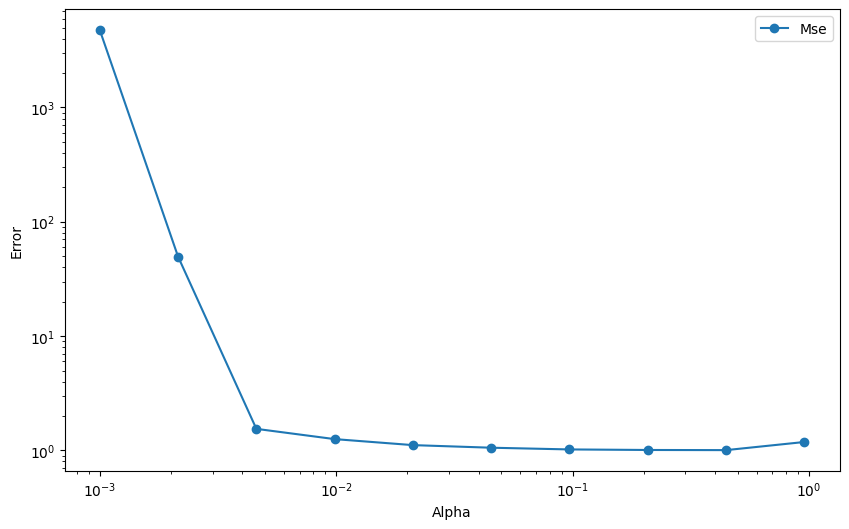

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(alphas, errors, marker="o", label="Mse")
plt.yscale("log")
plt.xlabel("Alpha")
plt.xscale("log")
plt.ylabel("Error")
plt.legend()

In [16]:
mu = 0.05

def mse_ridge(w: np.ndarray, X: np.ndarray, y: np.ndarray, mu = mu) -> float:
    y_preds = X @ w
    return (1/len(y)) * np.sum((y_preds - y)**2) + mu * np.sum(w[1:]**2)
 
def grad_mse_ridge(w: np.ndarray, X: np.ndarray, y: np.ndarray, mu = mu) -> np.ndarray:
    y_preds = X @ w
    return (2 / len(y)) * X.T @ (y_preds - y) + 2 * mu * np.concatenate(([0], w[1:]))

def mse_lasso(w: np.ndarray, X: np.ndarray, y: np.ndarray, mu = mu) -> float:
    y_preds = X @ w
    return (1/len(y)) * np.sum((y_preds - y)**2) + mu * np.sum(np.abs(w[1:]))
 
def grad_mse_lasso(w: np.ndarray, X: np.ndarray, y: np.ndarray, mu = mu) -> np.ndarray:
    y_preds = X @ w
    return (2 / len(y)) * X.T @ (y_preds - y) + mu * np.concatenate(([0], np.sign(w[1:])))


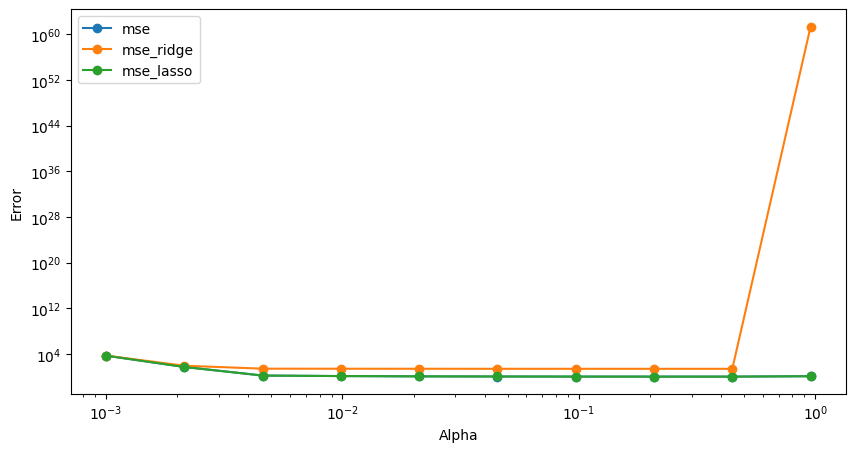

In [17]:
# 2

errors = {}

for cost, dcost in [(mse, grad_mse), (mse_ridge, grad_mse_ridge), (mse_lasso, grad_mse_lasso)]:
    errors[cost.__name__] = []
    for alpha in alphas:
        hyperparametros["alpha"] = alpha
        reg = RegresionLinealDG(cost, dcost, hyperparametros)
        reg.fit(X, y)
        err = error_prediccion(X, y, reg.w)
        errors[cost.__name__] += [err]

plt.figure(figsize=(10, 5))

for cost in [mse, mse_ridge, mse_lasso]:
    plt.plot(alphas, errors[cost.__name__], marker="o", label=cost.__name__)

plt.yscale("log")
plt.xlabel("Alpha")
plt.xscale("log")
plt.ylabel("Error")
plt.legend()


In [18]:
from sklearn.model_selection import train_test_split

# 3

class RegresionLinealDG():
    
    def __init__(self,
                 func_costo: Callable[..., float], 
                 func_costo_grad: Callable[..., np.ndarray], 
                 descenso_gradiente_hyperparams: Optional[Dict[str, Any]] = None):
        self.func_costo = func_costo
        self.func_costo_grad = func_costo_grad
        self.descenso_gradiente_hyperparams = descenso_gradiente_hyperparams
        self.collect_info = False
    
    def descenso_gradiente_mini_batch(self, X_train, y_train, z_init, alpha, num_iterations, tol, batch_size, verbose=False):
        z = z_init
        n = X_train.shape[0]

        for k in range(num_iterations):
            np.random.seed(k)
            perm = np.random.permutation(n)
            X_recidual = X_train[perm]
            y_recidual = y_train[perm]

            for start in range(0, n, batch_size):
                X_batch = X_recidual[start : start + batch_size]
                y_batch = y_recidual[start : start + batch_size]

                # computa el gradiente para el mini-batch
                col_ones = np.ones((X_batch.shape[0], 1))
                X_batch_ext = np.hstack((col_ones, X_batch))

                g = partial(self.func_costo, X=X_batch_ext, y=y_batch)
                dg = partial(self.func_costo_grad, X=X_batch_ext, y=y_batch)    
                gradient = dg(z)

                # actualiza los parametros
                z_new = z - (alpha * gradient)

                if abs(g(z_new) - g(z)) < tol:
                    return z_new

                z = z_new
        return z

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        w_shape = X.shape[1] + 1
        self.w = self.descenso_gradiente_mini_batch(X, y,
                        z_init=np.zeros(w_shape), 
                        **self.descenso_gradiente_hyperparams)

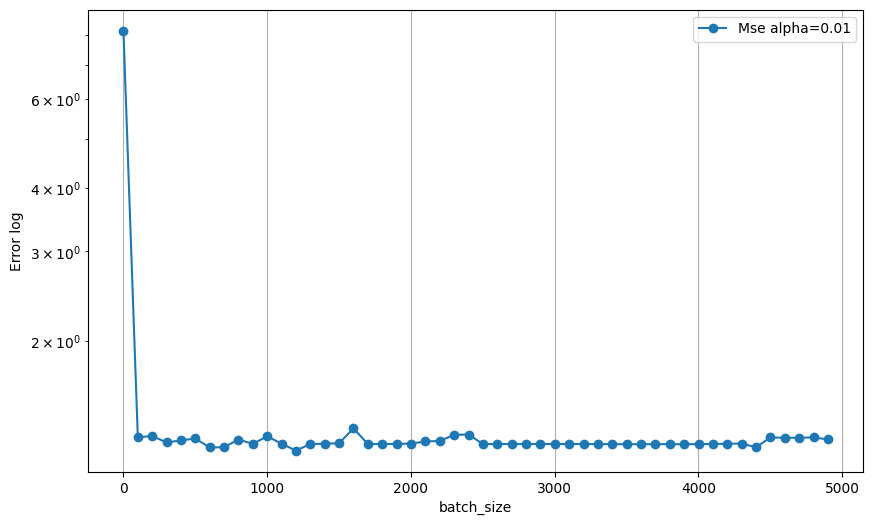

In [19]:
hyperparametros = {"num_iterations": 1000, "tol": 0.01, "alpha": 0.01}
batch_sizes = np.arange(1, len(X), 100)
errors = [] 

for batch_size in batch_sizes:
    hyperparametros["batch_size"] = batch_size
    reg = RegresionLinealDG(mse, grad_mse, hyperparametros)
    reg.fit(X,y)
    err = error_prediccion(X, y, reg.w)
    errors.append(err)

plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, errors, marker="o", label="Mse alpha=0.01")
plt.xlabel("batch_size")
plt.ylabel("Error log")
plt.yscale("log")
plt.grid(True)
plt.legend()

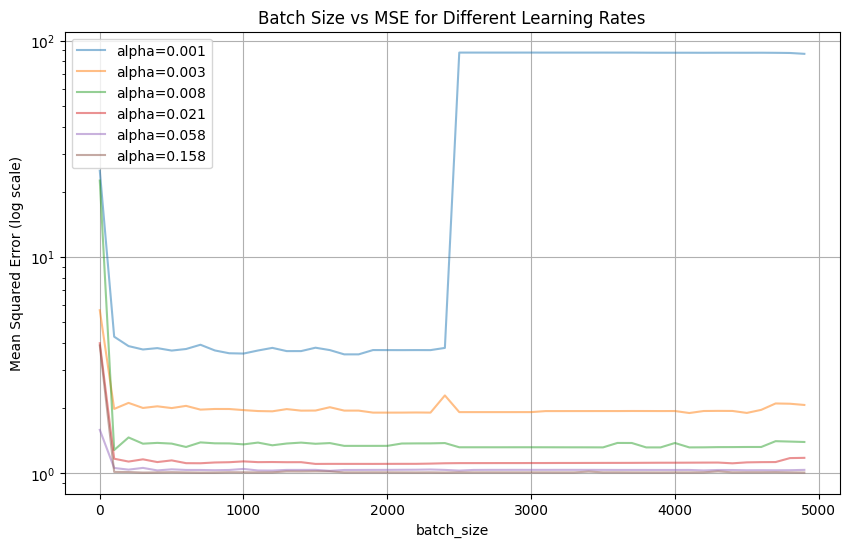

In [20]:
alphas = np.logspace(-3, -0.8, 6)

base_hyperparams = {"num_iterations": 1000, "tol": 0.01}
batch_sizes = np.arange(1, len(X), 100)

plt.figure(figsize=(10, 6))

for alpha in alphas:
    errors = []
    hyperparametros = base_hyperparams.copy()
    hyperparametros["alpha"] = alpha

    for batch_size in batch_sizes:
        hyperparametros["batch_size"] = batch_size
        reg = RegresionLinealDG(mse, grad_mse, hyperparametros)
        reg.fit(X, y)
        err = error_prediccion(X, y, reg.w)
        errors.append(err)

    plt.plot(batch_sizes, errors, alpha=.5, label=f"alpha={round(alpha, 3)}")

plt.xlabel("batch_size")
plt.ylabel("Mean Squared Error (log scale)")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.title("Batch Size vs MSE for Different Learning Rates")
plt.show()